In [1]:
%matplotlib inline
from  pycocotools.coco import COCO
import numpy as np
import skimage.io as io
import matplotlib.pyplot as plt
import pylab

import matplotlib.patches as patches # For bounding boxes
from PIL import Image
from collections import defaultdict
import json
from tqdm import tqdm_notebook
import os 
import urllib.request
import cv2 as cv
import time

plt.rcParams['figure.figsize'] = (15, 15)

In [2]:
dataDir = "COCOdataset2017"

dataValType   = 'val2017'
dataTrainType = 'train2017'

annValFile   ='{}/annotations/instances_{}.json'.format(dataDir,dataValType)
annTrainFile ='{}/annotations/instances_{}.json'.format(dataDir,dataTrainType)

In [3]:
# Define paths

dataDir = "COCOdataset2017"
dataValType   = 'val2017'
dataTrainType = 'train2017'
annValFile    ='{}/annotations/instances_{}.json'.format(dataDir,dataValType)
annTrainFile  ='{}/annotations/instances_{}.json'.format(dataDir,dataTrainType)

DATA_SOURCE_DIR = "./COCOdataset2017/images"
ANN_DIR   = os.path.join(DATA_SOURCE_DIR, "annotations")
TRAIN_DIR = os.path.join(DATA_SOURCE_DIR, "train")
VAL_DIR   = os.path.join(DATA_SOURCE_DIR, "val")
TEST_DIR  = os.path.join(DATA_SOURCE_DIR, "test")

YOLO_DIR       = "yolo"
YOLO_SETTINGS  = os.path.join(YOLO_DIR, "yolo_settings")
YOLOV3_CFG     = os.path.join(YOLO_SETTINGS, "v3/yolov3.cfg")
YOLOV3_WEIGHTS = os.path.join(YOLO_SETTINGS, "v3/yolov3.weights")

YOLOV4_CFG      = os.path.join(YOLO_SETTINGS, "v4/yolov4.cfg")
YOLOV4_WEIGHTS  = os.path.join(YOLO_SETTINGS, "v4/yolov4.weights")

IMAGES_FOLDER     = os.path.join(dataDir, "images")
TRAINING_IMAGE    = os.path.join(IMAGES_FOLDER, "train")
VALIDATION_IMAGE  = os.path.join(IMAGES_FOLDER, "val")

In [4]:
# init COCO api for instance annotations 
cocoTrain = COCO(annTrainFile)
cocoVal   = COCO(annValFile)

loading annotations into memory...
Done (t=21.72s)
creating index...
index created!
loading annotations into memory...
Done (t=0.51s)
creating index...
index created!


In [5]:
# Get all categories
cats = cocoTrain.loadCats(cocoTrain.getCatIds())

# Print categories
nms=[cat['name'] for cat in cats]
print(f"{len(cats)} categories: \n{', '.join(nms)}")

80 categories: 
person, bicycle, car, motorcycle, airplane, bus, train, truck, boat, traffic light, fire hydrant, stop sign, parking meter, bench, bird, cat, dog, horse, sheep, cow, elephant, bear, zebra, giraffe, backpack, umbrella, handbag, tie, suitcase, frisbee, skis, snowboard, sports ball, kite, baseball bat, baseball glove, skateboard, surfboard, tennis racket, bottle, wine glass, cup, fork, knife, spoon, bowl, banana, apple, sandwich, orange, broccoli, carrot, hot dog, pizza, donut, cake, chair, couch, potted plant, bed, dining table, toilet, tv, laptop, mouse, remote, keyboard, cell phone, microwave, oven, toaster, sink, refrigerator, book, clock, vase, scissors, teddy bear, hair drier, toothbrush


In [6]:
def getImages(coco, subCats):

    # Specify classes to download
    catIds      = coco.getCatIds(catNms=subCats)

    # get image ids
    imgIds = coco.getImgIds(catIds=catIds)

    # Load images ids
    images = coco.loadImgs(imgIds)

    return catIds, imgIds, images 

In [7]:
subCats = ['person', 'car', 'bicycle']

In [8]:
catTrainIds, imgTrainIds, trainImages = getImages(cocoTrain, subCats)
catValIds, imgValIds, valImages   = getImages(cocoVal, subCats)

In [9]:
print(f"number of 2017 training   COCO images in {subCats} is {len(trainImages)}")
print(f"number of 2017 validation COCO images in {subCats} is {len(valImages)}")

number of 2017 training   COCO images in ['person', 'car', 'bicycle'] is 1101
number of 2017 validation COCO images in ['person', 'car', 'bicycle'] is 45


In [10]:
# Load names of classes and get random colors
classes = open(os.path.join(YOLO_SETTINGS, 'coco.names')).read().strip().split('\n')
np.random.seed(42)
colors = np.random.randint(0, 255, size=(len(classes), 3), dtype='uint8')

In [11]:
cat_index_to_name = dict()
cat_name_to_index = dict()
cats = cocoTrain.loadCats(cocoTrain.getCatIds())

for cat in cats:
    cat_index_to_name[cat['id']]   = cat['name']
    cat_name_to_index[cat['name']] = cat['id']

In [29]:
class objectDetectorYolo:
    def __init__(self, yolo_cfg, 
                 yolo_weight, 
                 subClass=[], 
                 conf_threshold = 0.5,
                 nms_threshold = 0.4,
                 scaleFactor=1/255, 
                 inputImageSize=(640, 640), 
                 meanValToSubtract = (0,0,0),
                 active_gpu=False):
        
        # yolo conf
        self.yolo_cfg       = yolo_cfg
        self.yolo_weight    = yolo_weight

        # params of input blob
        self.subClass       = subClass
        self.scaleFactor    = scaleFactor
        self.inputImageSize = inputImageSize
        self.meanValToSubtract = meanValToSubtract

        # params conf of post_processing
        self.conf_threshold = conf_threshold
        self.nms_threshold  = nms_threshold

        self.preds = []
        self.active_gpu = active_gpu
        self.net   = self.load_models(active_gpu)

        self.infer_times = []

    
    def load_models(self, active_gpu=False):

        net = cv.dnn.readNetFromDarknet(str(self.yolo_cfg), 
                                        str(self.yolo_weight))

        if (active_gpu):
            try:
                net.setPreferableBackend(cv.dnn.DNN_BACKEND_CUDA)
                net.setPreferableTarget(cv.dnn.DNN_TARGET_CUDA_FP16)
            except:
                net.setPreferableTarget(cv.dnn.DNN_TARGET_CUDA)
        else:
            net.setPreferableBackend(cv.dnn.DNN_BACKEND_OPENCV)        

        return net
    
    

    def pre_processing(self, inputImage):
        # Create a 4D blob from a frame.
        # generate blobs from input image
        inputBlob = cv.dnn.blobFromImage(inputImage,  scalefactor = self.scaleFactor, size = self.inputImageSize, swapRB=True, crop=False)
        self.net.setInput(inputBlob)
        # set blob into 
        #outputs = self.net.forward(self.net.getUnconnectedOutLayersNames())
        outputs = self.net.forward(self.get_ouputs_name())
        return outputs
    


    def get_ouputs_name(self):
        layer_names = self.net.getLayerNames()
        try:
            ouput_layers = [layer_names[i-1]    for i in self.net.getUnconnectedOutLayers()]
        except:
            ouput_layers = [layer_names[i[0]-1] for i in self.net.getUnconnectedOutLayers()]
        
        return ouput_layers
    

    
    def post_processing(self, inputImage, outputs):
        outputs = np.vstack(outputs)
        H, W = inputImage.shape[:2]

        boxes       = []
        confidences = []
        classIDs    = []

        for output in outputs:
            scores = output[5:]
            classID = np.argmax(scores)
            confidence = scores[classID]
            if confidence > self.conf_threshold:
                x, y, w, h = output[:4] * np.array([W, H, W, H])
                p0 = int(x - w//2), int(y - h//2)
                p1 = int(x + w//2), int(y + h//2)
                boxes.append([*p0, int(w), int(h)])
                confidences.append(float(confidence))
                classIDs.append(classID)
                                    
        indices = cv.dnn.NMSBoxes(boxes, confidences, self.conf_threshold, self.nms_threshold)

        if len(self.subClass) > 0:
            user_indices = np.array([i for i in indices if classes[classIDs[i]] in self.subClass])
        else:
            user_indices = indices

        if len(user_indices) > 0:
            for i in user_indices:
                (x, y) = (boxes[i][0], boxes[i][1])
                (w, h) = (boxes[i][2], boxes[i][3])
                color = [int(c) for c in colors[classIDs[i]]]# Load names of classes and get random colors
                cv.rectangle(inputImage, (x, y), (x + w, y + h), color, 2)
                text = "{}: {:.4f}".format(classes[classIDs[i]], confidences[i])
                cv.putText(inputImage, text, (x, y - 5), cv.FONT_HERSHEY_SIMPLEX, 0.5, color, 1)
    
        return inputImage
    


    def get_preds(self):
        return self.preds
    

    def refresh_preds(self):
        self.preds.clear()
    

    def get_infer_times(self):
        return self.infer_times


    def detect_objects(self, inputImage,  show_detect_image=True):
        
        outputs    = self.pre_processing(inputImage=inputImage)
        img        = self.post_processing(inputImage.copy(), outputs)
        
        t, _ = self.net.getPerfProfile()
        label = 'Inference time: %.2f ms' % (t * 1000.0 /  cv.getTickFrequency())
        self.infer_times.append(t * 1000.0 /  cv.getTickFrequency())
        print(t * 1000.0 /  cv.getTickFrequency())
        cv.putText(img, label, (20, 40), cv.FONT_HERSHEY_SIMPLEX, fontScale = 0.7, color=(0, 0, 255))

        if show_detect_image == True:
            plt.imshow(cv.cvtColor(img, cv.COLOR_BGR2RGB))

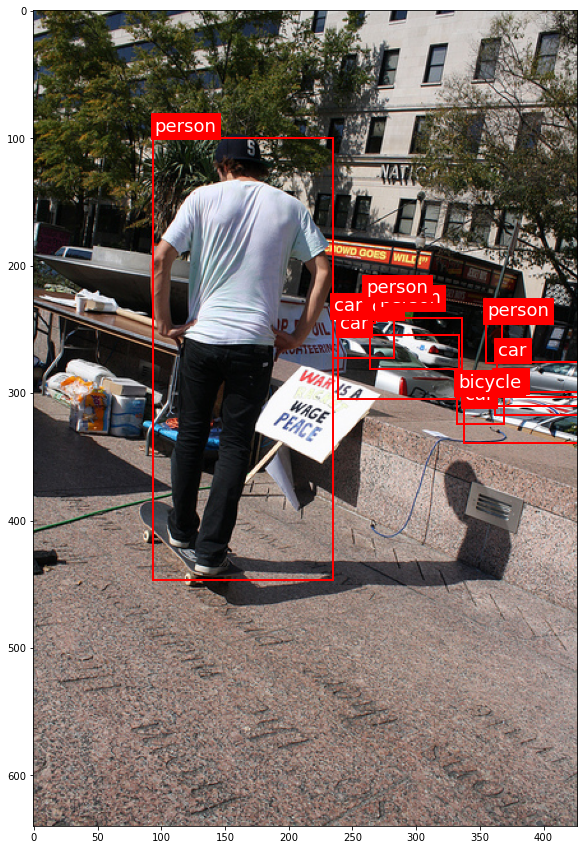

In [13]:
img_json = trainImages[np.random.randint(0, len(trainImages))]
img = cv.imread(os.path.join(TRAIN_DIR, img_json['file_name']))

ground_truths = []

annIds = cocoTrain.getAnnIds(img_json['id'], catIds=catTrainIds, iscrowd=None)
anns   = cocoTrain.loadAnns(annIds)

fig, ax = plt.subplots()

# visualize an image
img = Image.open(os.path.join(TRAIN_DIR, img_json['file_name']))

# visualize bbox im image
for ann in anns:
    ground_truth = {}

    bbox = ann['bbox']
    name_cat = cat_index_to_name[ann['category_id']]

    # extract bbox coordinates
    x = float(bbox[0])
    y = float(bbox[1])
    w = float(bbox[2])
    h = float(bbox[3])

    ground_truth["bbox"] = [x, y, w, h]
    ground_truth["label_name"] = name_cat
    ground_truths.append(ground_truth)

    # add text and bbox
    plt.text(x+1, y-5, name_cat,fontdict={'fontsize':18.0, 'fontweight':'medium','color': 'white', 'backgroundcolor':'red'})
    bb = patches.Rectangle((x, y), w, h, linewidth=2, edgecolor='red', facecolor='none')
    ax.add_patch(bb)

ax.imshow(img)


2914.366


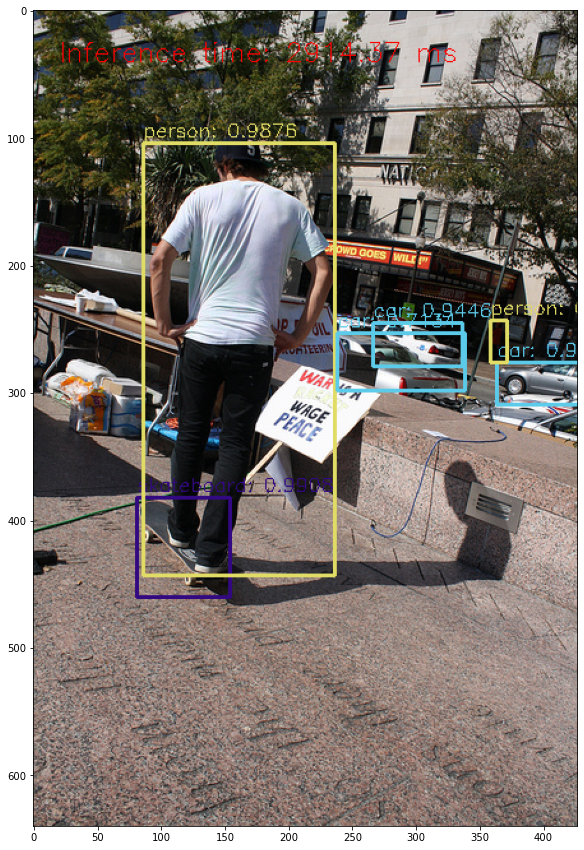

In [14]:
img = cv.imread(os.path.join(TRAIN_DIR, img_json['file_name']))
yolo_v3_detector = objectDetectorYolo(YOLOV3_CFG, YOLOV3_WEIGHTS, subClass=[], scaleFactor=1/255, conf_threshold=0.6, nms_threshold=0.4)
yolo_v3_detector.detect_objects(img)

In [15]:
VALIDATION_IMAGE

'COCOdataset2017\\images\\val'

In [16]:
yolo_v3_detector = objectDetectorYolo(YOLOV3_CFG, YOLOV3_WEIGHTS, scaleFactor=1/255, conf_threshold=0.6, nms_threshold=0.4)

for file_img in os.listdir(VALIDATION_IMAGE):
    img_path = os.path.join(VALIDATION_IMAGE, file_img)
    image = cv.imread(img_path)
    yolo_v3_detector.detect_objects(image, show_detect_image=False)

2326.3123
718.7213
771.1607
785.6768
809.4277
755.3137
748.1446
740.419
743.1442
701.5725
677.2274
635.167
669.9591
635.0627
647.0508
641.7492
645.0443
661.6101
658.2881
748.0357
649.7646
637.4783
628.1999
633.6031
638.9517
667.034
659.7997
663.9976
657.8503
670.6123
661.6039
642.887
645.0889
634.0338
634.8717
640.1463
632.6697
629.4454
638.6178
637.9539
741.9226
654.874
642.8538
637.0498
635.2413


In [17]:
from statistics import mean

print( f"YOLOV3 Inference times: {mean(yolo_v3_detector.get_infer_times())}, FPS: {1000 / mean(yolo_v3_detector.get_infer_times())}")

YOLOV3 Inference times: 709.6808577777778, FPS: 1.409084082007366


In [18]:
yolo_v4_detector = objectDetectorYolo(YOLOV4_CFG, YOLOV4_WEIGHTS, scaleFactor=1/255, conf_threshold=0.6, nms_threshold=0.4)

for file_img in os.listdir(VALIDATION_IMAGE):
    img_path = os.path.join(VALIDATION_IMAGE, file_img)
    image = cv.imread(img_path)
    yolo_v4_detector.detect_objects(image, show_detect_image=False)

2829.7711
869.3064
728.3293
727.8684
732.7277
760.5259
750.6598
732.1138
809.5279
745.2423
1015.4918
1025.1135
1079.1254
1049.4366
910.3942
937.9076
1008.9108
1028.5963
1094.5053
991.868
1118.4009
969.5365
940.3388
919.7178
1011.655
926.6238
844.4476
844.2385
826.0995
745.0733
754.0524
764.8597
748.2179
742.0249
777.2571
758.6751
817.1902
791.5193
778.2796
735.9451
775.0562
770.43
773.307
783.9602
895.4213


In [19]:
print( f"YOLOV4 Inference times: {mean(yolo_v4_detector.get_infer_times())}, FPS: {1000 / mean(yolo_v4_detector.get_infer_times())}")

YOLOV4 Inference times: 903.1055511111111, FPS: 1.1072902815951884


In [27]:
VALIDATION_IMAGE

'COCOdataset2017\\images\\val'

2414.1355


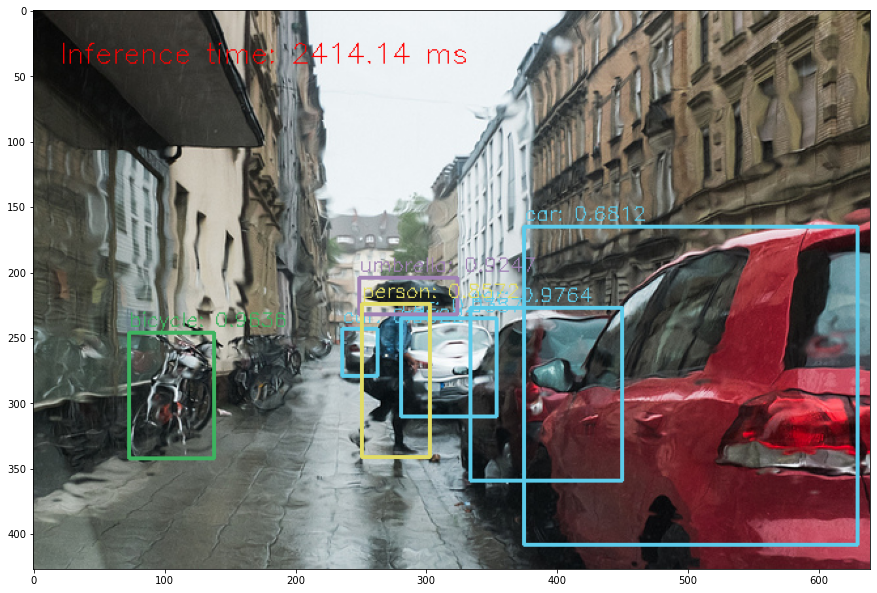

In [32]:
yolo_v3_detector = objectDetectorYolo(YOLOV3_CFG, YOLOV3_WEIGHTS, scaleFactor=1/255, conf_threshold=0.6, nms_threshold=0.4)

img = cv.imread(os.path.join(TRAINING_IMAGE, "000000216711.jpg"))
yolo_v3_detector.detect_objects(img)

762.4763


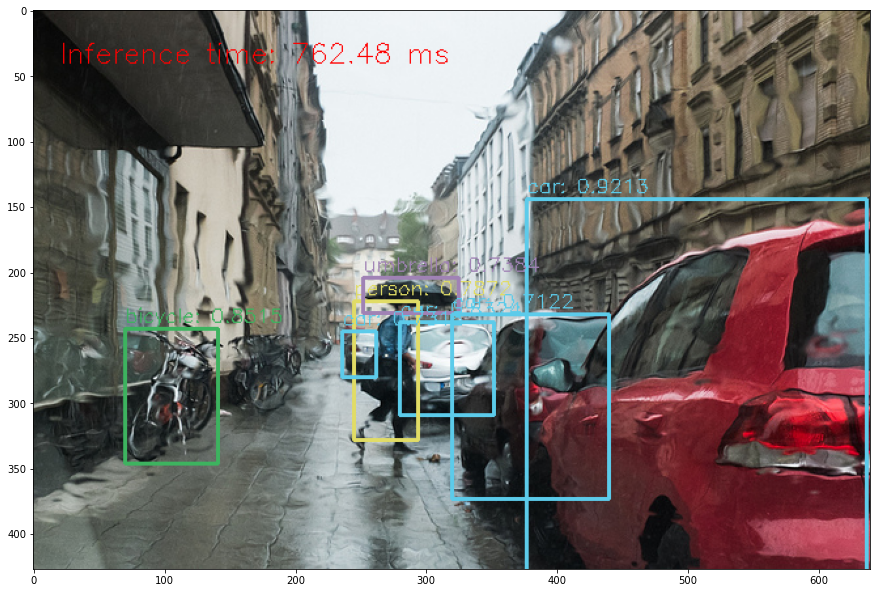

In [50]:
img = cv.imread(os.path.join(TRAINING_IMAGE, "000000216711.jpg"))
yolo_v4_detector.detect_objects(img)

In [20]:
yolo_v3_detector = objectDetectorYolo(YOLOV3_CFG, YOLOV3_WEIGHTS, scaleFactor=1/255, conf_threshold=0.6, nms_threshold=0.4,active_gpu=True)

for file_img in os.listdir(VALIDATION_IMAGE):
    img_path = os.path.join(VALIDATION_IMAGE, file_img)
    image = cv.imread(img_path)
    yolo_v3_detector.detect_objects(image, show_detect_image=False)

error: OpenCV(4.7.0) D:\a\opencv-python\opencv-python\opencv\modules\dnn\src\net_impl.cpp:102: error: (-215:Assertion failed) preferableBackend != DNN_BACKEND_OPENCV || preferableTarget == DNN_TARGET_CPU || preferableTarget == DNN_TARGET_OPENCL || preferableTarget == DNN_TARGET_OPENCL_FP16 in function 'cv::dnn::dnn4_v20221220::Net::Impl::validateBackendAndTarget'


666.7399


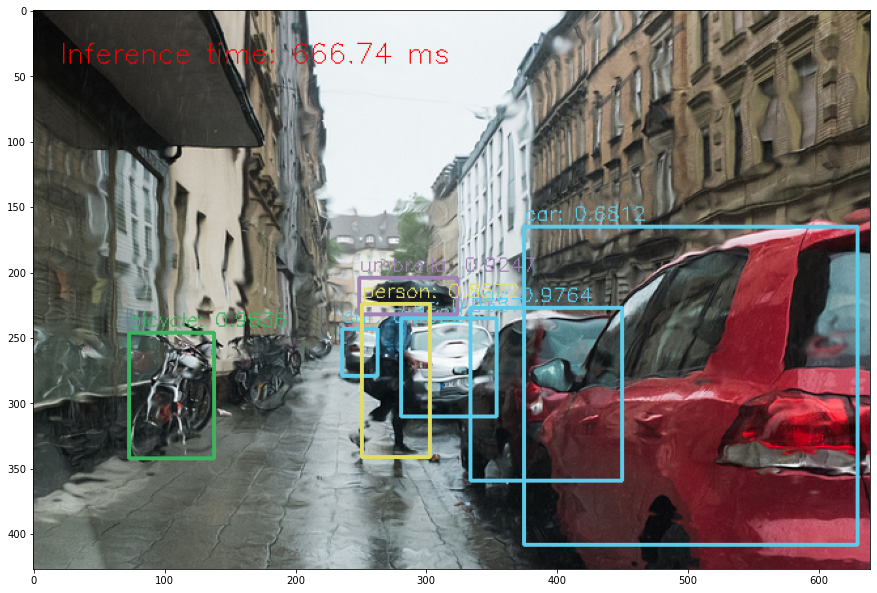

In [43]:

img = cv.imread(os.path.join(TRAINING_IMAGE, "000000216711.jpg"))
yolo_v3_detector.detect_objects(img)

In [ ]:
print( f"YOLOV3 Inference times with GPU: {mean(yolo_v3_detector.get_infer_times())}, FPS: {1 / mean(yolo_v3_detector.get_infer_times())/1000}")

YOLOV3 Inference times with GPU: 678.6372622222223, FPS: 1.4735412504840417e-06


In [ ]:


import cv2
import numpy as np
import time

confidence_threshold = 0.5
nms_threshold = 0.4
num_classes = 80

net = cv2.dnn.readNet(YOLOV3_CFG, YOLOV3_WEIGHTS)
net.setPreferableBackend(cv2.dnn.DNN_BACKEND_CUDA)
net.setPreferableTarget(cv2.dnn.DNN_TARGET_CUDA)

frame = np.random.randint(255, size=(416, 416, 3), dtype=np.uint8) # put your image here!
blob = cv2.dnn.blobFromImage(frame, 0.00392, (416, 416), [0, 0, 0], True, False)

# warmup
for i in range(3):
    net.setInput(blob)
    detections = net.forward(net.getUnconnectedOutLayersNames())

# benchmark
start = time.time()
for i in range(100):
    net.setInput(blob)
    detections = net.forward(net.getUnconnectedOutLayersNames())
end = time.time()

ms_per_image = (end - start) * 1000 / 100

print("Time per inference: %f ms" % (ms_per_image))
print("FPS: ", 1000.0 / ms_per_image)

Time per inference: 339.510112 ms
FPS:  2.945420372525554


In [ ]:


import cv2
import numpy as np
import time

confidence_threshold = 0.5
nms_threshold = 0.4
num_classes = 80

net = cv2.dnn.readNet(YOLOV3_CFG, YOLOV3_WEIGHTS)
net.setPreferableBackend(cv2.dnn.DNN_BACKEND_CUDA)
net.setPreferableTarget(cv2.dnn.DNN_TARGET_CUDA)

In [ ]:
def is_cuda_cv(): # 1 == using cuda, 0 = not using cuda
    try:
        count = cv2.cuda.getCudaEnabledDeviceCount()
        if count > 0:
            return 1
        else:
            return 0
    except:
        return 0

is_cuda_cv()

0

In [22]:
import torch
CUDA = torch.cuda.is_available()
CUDA

True